# Sparkify: Predict Customer Churn with PySpark

In this project I will use user log data of the fictional music streaming provider Sparkify in order to predict customer churn. Customer churn refers to the direct or indirect  cancellation of a service by the customer. For the service provider it often goes hand in hand with a permanent loss of the customer relationship. Companies therefore have great 
interest in technologies that help them to identify customers with a high churn risk in advance.

I will demonstrate the full process of churn prediction in seven steps:

* Data Loading
* Data Exploration
* Data Cleaning
* Feature Engineering
* Model Training
* Model Selection
* Evaluation

In [141]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from datetime import datetime
import time
pd.set_option("display.max_columns", 120)

## Load Data

In this section I create a Spark session and load the user log data sample.

In [6]:
# Create a Spark session
spark = SparkSession.builder.appName('sparkify').master('local[*]').getOrCreate()

In [7]:
# Load the user log data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

## Explore Data

In this section I provide a general overview of the dataset. By doing so, I want to take up requirements for the data cleaning process and develop first ideas for feature generation.

### Overview

In [8]:
# Take a look on the first three rows
user_log.toPandas().head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Data types

In [9]:
# Print data types
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Investigate non numeric user IDs
user_log.filter('userid not rlike "[0-9]+"').select('userid').dropDuplicates().collect()

[Row(userid='')]

In [11]:
# Investigate authentication of non numeric user IDs
user_log.filter(user_log.userId == "").select('auth').dropDuplicates().collect()

[Row(auth='Logged Out'), Row(auth='Guest')]

All columns have appropriate data types, except the `userId` column. I will later drop events of unregistered users (those with `userId = ''`) and then convert the variable from string to integer.

### Missing values

In [12]:
# Count missing values
user_log.select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [13]:
# Count missing values only for registered users
cond1 = (user_log.userId != '')
user_log.filter(cond1).select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=50046, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=50046, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=50046, status=0, ts=0, userAgent=0, userId=0)]

In [14]:
# Count missing values only for registered users and song pages
cond2 = (user_log.page == "NextSong")
user_log.filter(cond1 & cond2).select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=0, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=0, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=0, status=0, ts=0, userAgent=0, userId=0)]

There seems to be no major issue with missing values. Missing values occur in user specific variables (`firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`) only for events of unregistered users (for which holds `userId == ''`), as well as in song specific variables (`artist`, `length`, `song`) for not song-related events (for which holds `page != "NextSong"`). 

### Timestamps

In [15]:
# Minimal and maximal registration date
user_log.select('registration').agg(F.from_unixtime(F.min('registration') / 1000, 'yyyy-MM-dd').alias('min')).collect(), \
user_log.select('registration').agg(F.from_unixtime(F.max('registration') / 1000, 'yyyy-MM-dd').alias('min')).collect()

([Row(min='2018-03-18')], [Row(min='2018-11-26')])

In [16]:
# Minimal and maximal event date
user_log.select('ts').agg(F.from_unixtime(F.min('ts') / 1000, 'yyyy-MM-dd').alias('min')).collect(), \
user_log.select('ts').agg(F.from_unixtime(F.max('ts') / 1000, 'yyyy-MM-dd').alias('min')).collect()

([Row(min='2018-10-01')], [Row(min='2018-12-03')])

This is an important insight for modeling on the small user log subset. There are users of which we don't have the full history (those who have registered before 2018-10-01). This is something we should consider in the feature generation phase, since otherwise, if we do not act wisely, our model could suffer from bias.

### Categorical variables

In [17]:
# Get number of unique values and top 10 values of categorical data
df = user_log.toPandas()
for col in df.columns[(df.dtypes == 'object') & (df.columns!='userId')]:
    top10 = df[col].value_counts().index[:10].tolist()
    print(col + " ({})".format(df[col].nunique()))
    print(top10)

artist (17655)
['Kings Of Leon', 'Coldplay', 'Florence + The Machine', 'Dwight Yoakam', 'BjÃ\x83Â¶rk', 'The Black Keys', 'Muse', 'Justin Bieber', 'Jack Johnson', 'Eminem']
auth (4)
['Logged In', 'Logged Out', 'Guest', 'Cancelled']
firstName (189)
['Payton', 'Riley', 'Lucero', 'Emilia', 'Emma', 'Joseph', 'Colin', 'Nicole', 'Joshua', 'Brayden']
gender (2)
['F', 'M']
lastName (173)
['Campbell', 'Reed', 'Williams', 'Taylor', 'Johnson', 'Larson', 'House', 'Thompson', 'Jones', 'Beck']
level (2)
['paid', 'free']
location (114)
['Los Angeles-Long Beach-Anaheim, CA', 'New York-Newark-Jersey City, NY-NJ-PA', 'Boston-Cambridge-Newton, MA-NH', 'Houston-The Woodlands-Sugar Land, TX', 'Charlotte-Concord-Gastonia, NC-SC', 'Dallas-Fort Worth-Arlington, TX', 'Louisville/Jefferson County, KY-IN', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 'Chicago-Naperville-Elgin, IL-IN-WI', 'St. Louis, MO-IL']
method (2)
['PUT', 'GET']
page (22)
['NextSong', 'Home', 'Thumbs Up', 'Add to Playlist', 'Add Friend', 'R

### Numerical variables

In [18]:
# Get description of numerical variables
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Activity over time

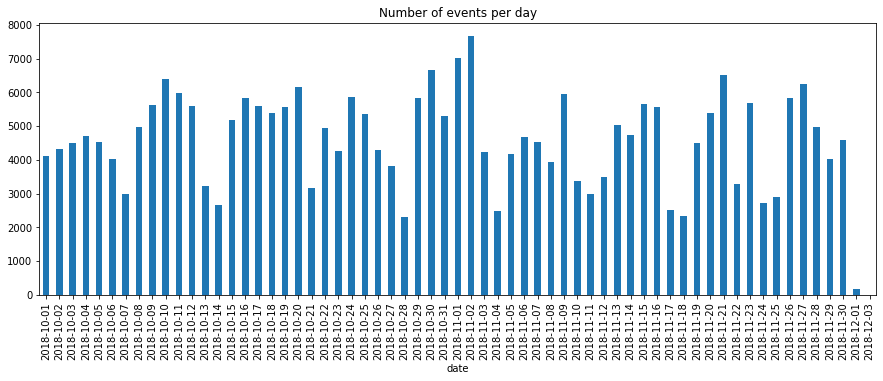

In [19]:
# Plot events per day
get_date =  F.udf(lambda x: datetime.fromtimestamp(x/1000), DateType())
events_per_date = user_log.withColumn('date', get_date('ts')).groupBy('date').count().alias('events')
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per day")
events_per_date.toPandas().set_index('date').sort_index().plot(kind='bar', ax=ax)
ax.get_legend().remove()
plt.show()

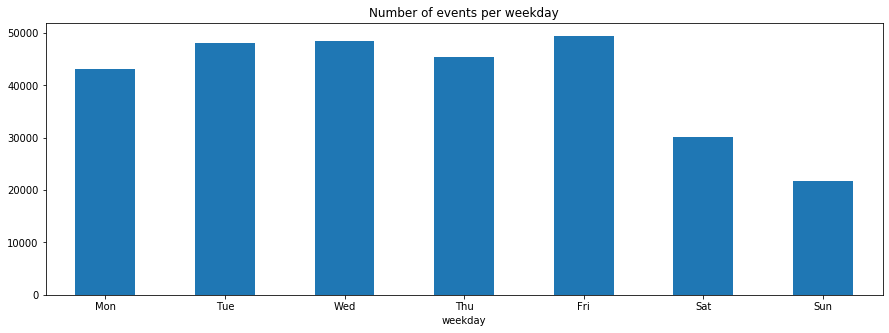

In [20]:
# Plot events per weekday
get_weekday = F.udf(lambda x: datetime.fromtimestamp(x/1000).weekday(), IntegerType())
events_per_weekday = user_log.withColumn('weekday', get_weekday('ts')).groupBy('weekday').count()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per weekday")
events_per_weekday.toPandas().set_index('weekday').sort_index().plot(kind='bar', ax=ax)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
ax.xaxis.set_tick_params(rotation=0)
ax.get_legend().remove()
plt.show()

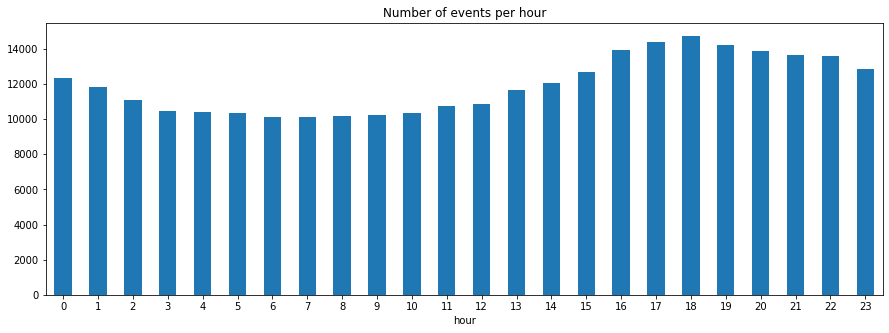

In [21]:
# Plot events per hour
get_hour = F.udf(lambda x: datetime.fromtimestamp(x/1000).hour, IntegerType())
events_per_hour = user_log.withColumn('hour', get_hour('ts')).groupBy('hour').count()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per hour")
events_per_hour.toPandas().set_index('hour').sort_index().plot(kind='bar', ax=ax)
ax.xaxis.set_tick_params(rotation=0)
ax.get_legend().remove()
plt.show()

### Number of events per page

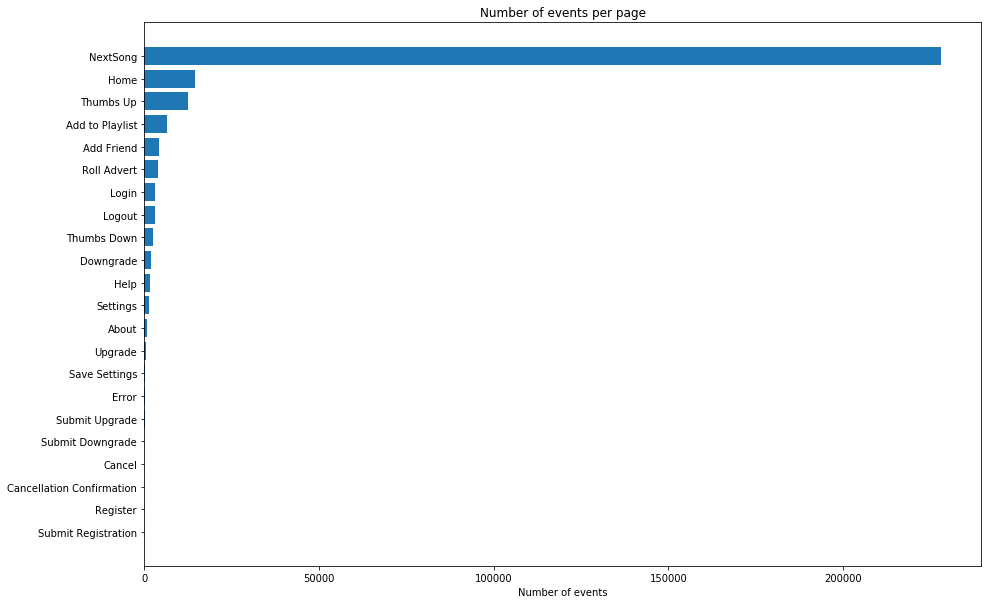

In [22]:
# Plot number of events per page
num_events_per_page = user_log.groupBy('page').count().toPandas().sort_values('count')
plt.figure(figsize=(15, 10))
plt.title("Number of events per page")
plt.barh(num_events_per_page['page'], num_events_per_page['count'])
plt.xlabel("Number of events")
plt.show()

## Clean Data

In this section I remove all events of unregistered users from the dataset and create a list of user IDs from registered users who have churned. We can identify these users by looking into the 'page' variable which provides information about the specific event a user has made. For all churners this column will contain an entry with the value 'Cancellation Confirmation'. We will then use this list to assign a flag to all events of the original dataset.

### Remove unregistered users

In [23]:
def clean_user_log(user_log):
    """ Prepares the user log data for the feature generation process 
    
    Input:
        user_log (DataFrame) - the original user log data
        
    Output:
        DataFrame - cleansed user log data
    
    """

    # Cast userid column to integer and remove unregistered users
    user_log = user_log.withColumn('userId', user_log['userId'].cast(IntegerType()))
    user_log = user_log.filter(user_log.userId.isNotNull())
    
    return user_log

In [24]:
user_log = clean_user_log(user_log)
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [25]:
# Is the dataset clean now?
user_log.filter( (F.col('userId').isNull()) | (F.col('userId') == '')).collect()

[]

### Save churn users 

In [26]:
def get_churn_users(user_log):
    """ Gets the user IDs of churn users in user log
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
    
    Output:
        list - churn user IDs
    
    """
    
    churn_users = user_log.filter(F.col('page') == "Cancellation Confirmation")\
                      .select('userId').dropDuplicates()\
                      .rdd.flatMap(lambda x: x).collect()
    
    return churn_users

In [27]:
churn_users = get_churn_users(user_log)
print("There are {} churn users in the sample".format(len(churn_users)))
print("Examples:", churn_users[:5])

There are 52 churn users in the sample
Examples: [200001, 53, 100003, 200021, 100007]


### Create flag for churn users and remove cancellation events

In [28]:
def create_churn_flag(user_log, churn_users):
    """ Adds churn flag to each event of the user log and removes 
    cancellation events
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - new user log data set
    
    """
    
    # Create churn user flag for user log data
    is_churn_user = F.udf(lambda x: int(x in churn_users), IntegerType())
    user_log = user_log.withColumn('churn', is_churn_user('userId'))
    
    # Remove cancellation events
    user_log = user_log.filter(~F.col('page').isin(["Cancellation Confirmation", "Cancel"]))
    
    return user_log

In [29]:
user_log = create_churn_flag(user_log, churn_users)
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [30]:
# Are the cancellation events removed?
user_log.filter(user_log.page.isin(["Cancellation Confirmation", "Cancel"])).collect()

[]

## Generate Features

Feature engineering is the most crucial step for the success of this project. On the one hand, the machine learning algorithms used at the end of this notebook can only be as good as the input factors we are feeding them with. On the other hand, especially since we are working only with a subset of the full user log history, poorly designed features could introduce biases to our models. 

After some additional experimentation and data exploration, I end with 9 features that we will use for the model training:

* Gender
* Location
* Device
* Payment status
* Number of sessions per week
* Average session length
* Days since registration
* Share per page
* Average plays per song

### Gender

In [31]:
def get_gender(user_log):
    """ Gets the gender of each user 
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
    
    Output:
        DataFrame - gender per user
    
    """
    
    # Get and encode gender per user
    gender = user_log.withColumn('gender', F.when(F.col('gender') == 'M', 1).otherwise(0))\
                     .select('userId', 'gender').dropDuplicates()
    
    return gender

In [32]:
gender = get_gender(user_log)

In [33]:
# Make pandas dataframe for exploration
gender_pandas = gender.toPandas()
gender_pandas['churn'] = gender_pandas['userId'].isin(churn_users).astype(int)
gender_pandas.head()

,userId,gender,churn
0,105,1,1
1,62,1,0
2,88,0,0
3,141,0,0
4,58,1,1


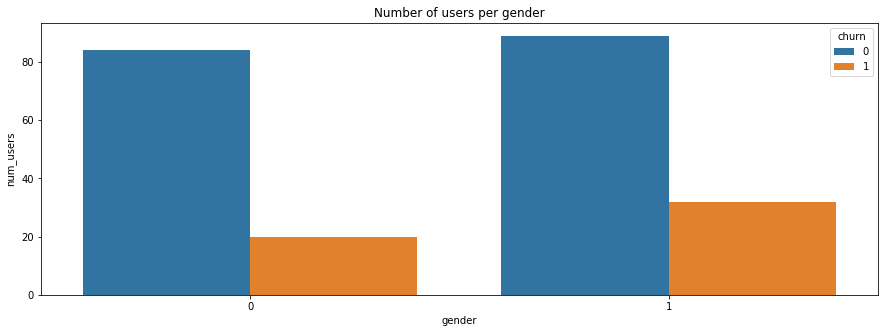

In [34]:
# Plot number of users per gender
gender_pandas_plot = gender_pandas.groupby(['gender', 'churn'], as_index=False).count()
gender_pandas_plot.columns = ['gender', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per gender")
sns.barplot(x = 'gender', y = 'num_users', hue = 'churn', data = gender_pandas_plot)
plt.show()

### Metropolian Area

In [35]:
def get_metropolian_area_dummies(user_log):
    """ Creates dataframe with dummies for the metropolian area users are 
    living in. The information can be extracted from the `location` column in
    the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded metropolian area of each user
    
    """
    
    # Create metropolian area feature
    get_state = F.udf(lambda x: x.split(', ')[1], StringType())
    user_log = user_log.withColumn('area', get_state('location'))
    
    # Get dummies and fill missing values with 0
    area_dummies = user_log.select(['userId', 'area']).dropDuplicates()\
                            .groupBy('userId').pivot('area').count()
    area_dummies = area_dummies.fillna(0)
    
    return area_dummies

In [36]:
area = get_metropolian_area_dummies(user_log)

In [37]:
# Make pandas dataframe for exploration
area_pandas = area.toPandas()
area_pandas['churn'] = area_pandas['userId'].isin(churn_users).astype(int)
area_pandas.head()

,userId,AK,AL,AR,AZ,CA,CO,CT,DC-VA-MD-WV,FL,GA,GA-AL,IA,IL,IL-IN-WI,IL-MO,IN,KY,KY-IN,LA,MA-NH,MD,MD-WV,MI,MN-WI,MO-IL,MO-KS,MS,MT,NC,NC-SC,NE-IA,NH,NJ,NV,NY,NY-NJ-PA,OH,OH-KY-IN,OK,OR,OR-WA,PA,PA-NJ,PA-NJ-DE-MD,RI-MA,SC,SC-NC,TN,TN-MS-AR,TN-VA,TX,UT,UT-ID,VA,VA-NC,WA,WI,WV,churn
0,148,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,200001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


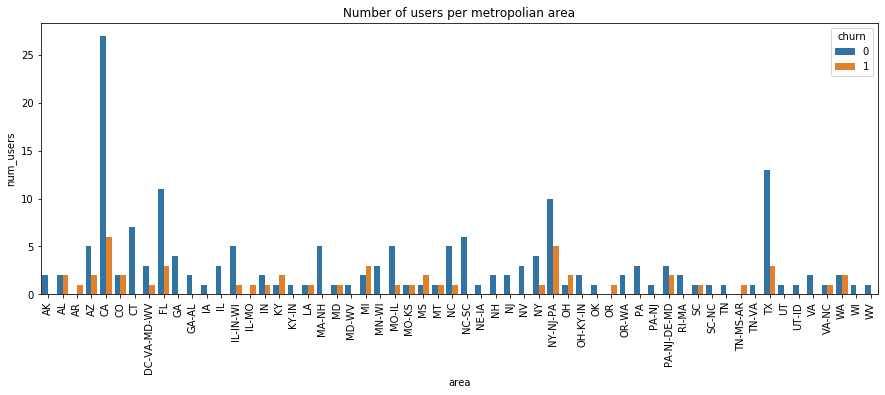

In [38]:
# Plot number of users per metropolian area
area_pandas_plot = area_pandas.groupby('churn').sum().drop('userId', axis=1).unstack().reset_index()
area_pandas_plot.columns = ['area', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per metropolian area")
sns.barplot(x = 'area', y = 'num_users', hue = 'churn', data = area_pandas_plot)
plt.xticks(rotation=90)
plt.show()

### Device

In [39]:
def get_device_dummies(user_log):
    """ Creates dataframe with dummies for the devices each user
    uses. The information can be extracted from the `userAgent`
    column in the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded devices of each user
    
    """
    
    # Create mapper for the derivation of device types
    device_mapper = {'Windows NT 6.1': 'Windows', 'Macintosh': 'Mac', 'Windows NT 6.0': 'Windows', 
                 'Windows NT 6.2': 'Windows', 'iPhone': 'iPhone', 'Windows NT 6.3': 'Windows', 
                 'iPad': 'iPad', 'compatible': 'Windows', 'X11': 'Linux', 
                 'Windows NT 5.1': 'Windows'}
    
    # Create device column 
    # Note: If device type is unknown, assign `unknown device` type
    get_device = F.udf(lambda x: device_mapper.get(re.findall(r'\((.+?)\)', x)[0].split(';')[0], 
                                                   'Unknown Device'), StringType() )
    user_log = user_log.withColumn('device', get_device('userAgent'))
    
    # Get dummies and fill missing values with 0
    device_dummies = user_log.select(['userId', 'device']).dropDuplicates()\
                            .groupBy('userId').pivot('device').count()
    device_dummies = device_dummies.fillna(0)
    
    return device_dummies

In [40]:
device = get_device_dummies(user_log)

In [41]:
# Make pandas dataframe for exploration
device_pandas = device.toPandas()
device_pandas['churn'] = device_pandas['userId'].isin(churn_users).astype(int)
device_pandas.head()

,userId,Linux,Mac,Windows,iPad,iPhone,churn
0,148,0,0,1,0,0,0
1,137,0,1,0,0,0,0
2,85,0,1,0,0,0,0
3,65,1,0,0,0,0,0
4,200001,0,0,1,0,0,1


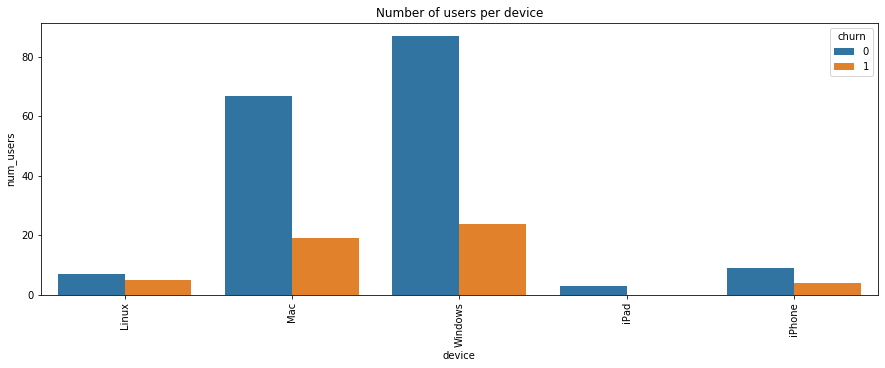

In [42]:
# Plot number of users per device
device_pandas_plot = device_pandas.groupby('churn').sum().drop('userId', axis=1).unstack().reset_index()
device_pandas_plot.columns = ['device', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per device")
sns.barplot(x = 'device', y = 'num_users', hue = 'churn', data = device_pandas_plot)
plt.xticks(rotation=90)
plt.show()

In [43]:
# Are there multidevice users?
device_pandas.loc[device_pandas.iloc[:,1:-1].sum(axis=1)>1, 'userId']

Series([], Name: userId, dtype: int32)

### Status

In [44]:
def get_current_status(user_log):
    """ Gets the current status of each user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - current status per user (0=unpaid, 1=paid)
    
    """
    
    # Get payment mode of last event of users
    window_var = Window().partitionBy('userId').orderBy(F.desc('ts'))
    current_status = user_log.withColumn('rn', F.row_number().over(window_var))\
                           .filter(F.col('rn')==1).select(['userId', 'level'])
    
    # Make binary feature (0=unpaid, 1=paid)
    is_user_paying = F.udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    current_status = current_status.withColumn('level', is_user_paying('level'))
    current_status = current_status.withColumnRenamed('level', 'Pay Status')
    
    return current_status

In [45]:
status = get_current_status(user_log)

In [46]:
# Make pandas dataframe for exploration
status_pandas = status.toPandas()
status_pandas['churn'] = status_pandas['userId'].isin(churn_users).astype(int)
status_pandas.head()

,userId,Pay Status,churn
0,148,0,0
1,85,1,0
2,137,1,0
3,65,1,0
4,200001,0,1


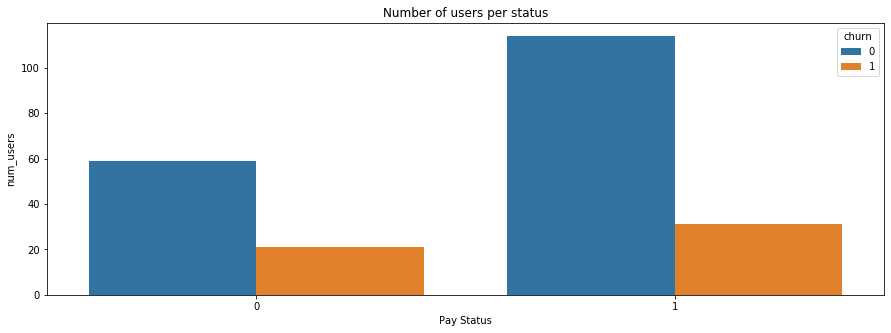

In [47]:
# Plot number of users per status
status_pandas_plot = status_pandas.groupby(['Pay Status', 'churn'], as_index=False).count()
status_pandas_plot.columns = ['Pay Status', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per status")
sns.barplot(x = 'Pay Status', y = 'num_users', hue = 'churn', data = status_pandas_plot)
plt.show()

### Number of sessions

In [48]:
def get_number_of_sessions(user_log):
    """ Calculates the average number of sessions per week for each user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average number of sessions per week per user
    
    """
    
    # Calculate length of observation period for each user
    start_date_min = user_log.agg({'ts': 'min'}).collect()[0][0]
    end_date_max = user_log.agg({'ts': 'max'}).collect()[0][0]
    window_var = Window().partitionBy('userId')
    user_log = user_log.withColumn('start_ts',\
                               F.when(F.col('registration') >= start_date_min, F.max(F.col('registration')).over(window_var))\
                               .otherwise(start_date_min))\
                       .withColumn('end_ts',\
                               F.when(F.col('churn') == 1, F.max(F.col('ts')).over(window_var))\
                               .otherwise(end_date_max))\
                       .withColumn('duration_weeks', (F.col('end_ts') - F.col('start_ts')) / (1000 * 60 * 60 * 24 * 7))
        
    # Calculate number of sessions per week and user
    num_sessions = user_log.groupBy('userId', 'duration_weeks')\
                           .agg((F.countDistinct('sessionId') / F.col('duration_weeks')).alias('Sessions Per Week'))\
                           .select('userId', 'Sessions Per Week')
    
    return num_sessions

In [49]:
sessions = get_number_of_sessions(user_log)

In [50]:
# Make pandas dataframe for exploration
sessions_pandas = sessions.toPandas()
sessions_pandas['churn'] = sessions_pandas['userId'].isin(churn_users).astype(int)
sessions_pandas.head()

,userId,Sessions Per Week,churn
0,148,1.332315,0
1,85,4.552077,0
2,137,0.333079,0
3,65,2.553604,0
4,200001,2.840479,1


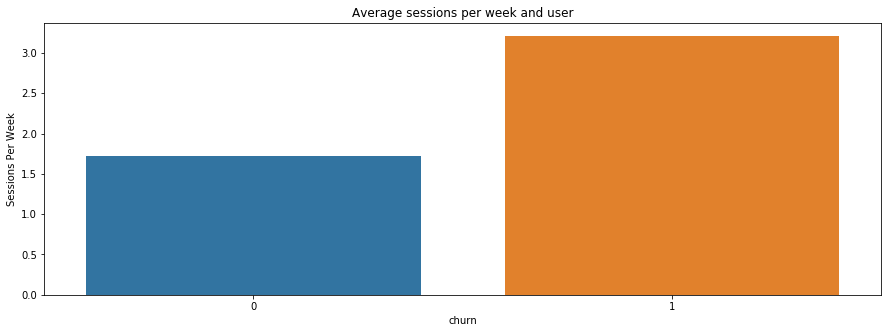

In [51]:
# Plot sessions per week and user
sessions_pandas_plot = sessions_pandas.groupby('churn', as_index=False)['Sessions Per Week'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average sessions per week and user")
sns.barplot(x = 'churn', y = 'Sessions Per Week', data = sessions_pandas_plot)
plt.show()

### Average session length

In [52]:
def calculate_session_length(user_log):
    """ Calculates the average length of all sessions of a user 
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average session length per user
    
    """

    # Calculate length per session
    session_length = user_log.groupBy(['userId', 'sessionId'])\
                             .agg((F.max('ts')-F.min('ts')).alias('session_length'))
    
    # Calculate average length of all sessions per user
    avg_session_length = session_length.groupBy('userId')\
                                       .agg((F.mean('session_length')/60000).alias('Length Per Session'))
    
    return avg_session_length

In [53]:
length = calculate_session_length(user_log)

In [54]:
# Make pandas dataframe for exploration
length_pandas = length.toPandas()
length_pandas['churn'] = length_pandas['userId'].isin(churn_users).astype(int)
length_pandas.head()

,userId,Length Per Session,churn
0,148,132.355556,0
1,85,370.846341,0
2,137,211.261111,0
3,200001,83.508333,1
4,65,384.174638,0


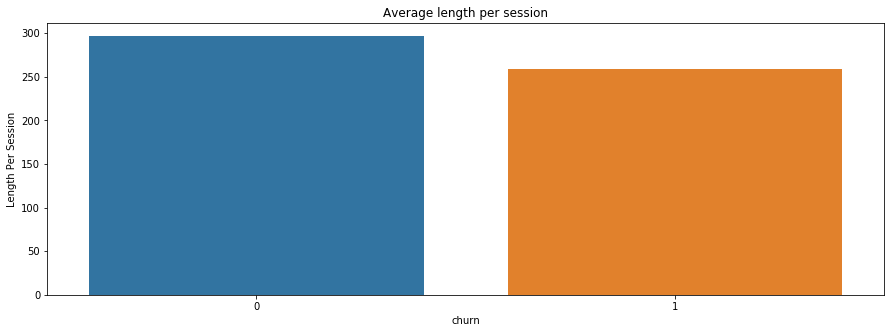

In [55]:
# Plot length per session 
length_pandas_plot = length_pandas.groupby('churn', as_index=False)['Length Per Session'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average length per session")
sns.barplot(x = 'churn', y = 'Length Per Session', data = length_pandas_plot)
plt.show()

### Days since registration

In [56]:
def calculate_days_since_registration(user_log):
    """ Calculates the number of days between the registration of a user 
    and the prediction date
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - days since registration
    
    """
    
    # Get prediction timestamp for each user
    end_date_max = user_log.agg({'ts': 'max'}).collect()[0][0]
    window_var = Window().partitionBy('userId')
    user_log = user_log.withColumn('end_ts',\
                               F.when(F.col('churn') == 1, F.max(F.col('ts')).over(window_var))\
                               .otherwise(end_date_max))
    
    # Calculate difference between prediction and registration timestamp
    registration = user_log.select('userId', 'registration', 'end_ts').dropDuplicates()\
                           .withColumn('Days Since Registration', (F.col('end_ts') - F.col('registration')) \
                                      / (1000 * 60 * 60 * 24))\
                           .select('userId', 'Days Since Registration')
    
    return registration

In [57]:
registration = calculate_days_since_registration(user_log)

In [58]:
# Make pandas dataframe for exploration
registration_pandas = registration.toPandas()
registration_pandas['churn'] = registration_pandas['userId'].isin(churn_users).astype(int)
registration_pandas.head()

,userId,Days Since Registration,churn
0,148,72.550926,0
1,85,111.870116,0
2,137,131.351968,0
3,65,74.678993,0
4,200001,15.908194,1


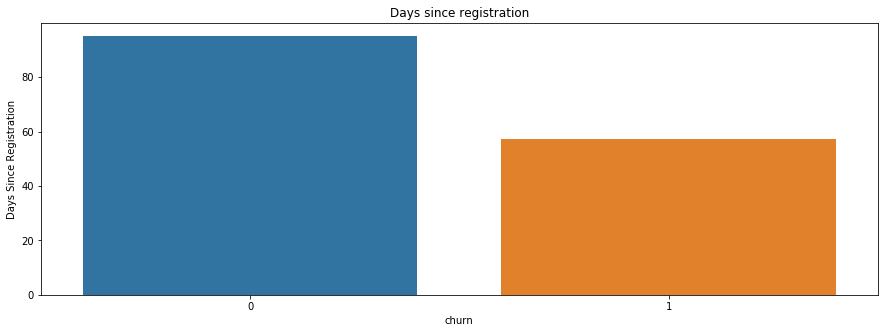

In [59]:
# Plot days since registration
registration_pandas_plot = registration_pandas.groupby('churn', as_index=False)['Days Since Registration'].mean()
plt.figure(figsize=(15, 5))
plt.title("Days since registration")
sns.barplot(x = 'churn', y = 'Days Since Registration', data = registration_pandas_plot)
plt.show()

### Page share

In [60]:
user_log.toPandas().page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings'], dtype=object)

In [61]:
def calculate_page_share(user_log):
    """ Calculates the share of each page on all events of a user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - page shares per user
    
    """

    
    vals = ['Home', 'NextSong', 'Roll Advert', 'Thumbs Up', 'Add Friend', 'Logout', 'Add to Playlist', 
            'Upgrade', 'Help', 'Settings', 'Thumbs Down', 'About', 'Submit Upgrade', 'Downgrade', 
            'Submit Downgrade', 'Error', 'Save Settings']
    
    pages = user_log.groupBy('userId', 'sessionId', 'itemInSession').pivot('page').count()
    pages = pages.na.fill(0)
    pages = pages.groupBy('userId').mean()
    pages = pages.select('userId', *(F.col("avg("+x+")").alias(x) for x in vals))
    
    return pages

In [62]:
pages = calculate_page_share(user_log)

In [63]:
# Make pandas dataframe for exploration
pages_pandas = pages.toPandas()
pages_pandas['churn'] = pages_pandas['userId'].isin(churn_users).astype(int)
pages_pandas.head()

,userId,Home,NextSong,Roll Advert,Thumbs Up,Add Friend,Logout,Add to Playlist,Upgrade,Help,Settings,Thumbs Down,About,Submit Upgrade,Downgrade,Submit Downgrade,Error,Save Settings,churn
0,148,0.050193,0.768340,0.061776,0.054054,0.013514,0.017375,0.009653,0.005792,0.005792,0.005792,0.005792,0.001931,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,85,0.035927,0.827460,0.007551,0.043936,0.013272,0.012357,0.024714,0.001602,0.005492,0.005721,0.008696,0.001373,0.000686,0.009611,0.000458,0.000458,0.000686,0
2,137,0.057416,0.736842,0.047847,0.038278,0.038278,0.023923,0.019139,0.019139,0.004785,0.004785,0.004785,0.000000,0.004785,0.000000,0.000000,0.000000,0.000000,0
3,65,0.031447,0.830582,0.003145,0.043632,0.020833,0.008255,0.026730,0.001179,0.005110,0.009041,0.006682,0.002358,0.000393,0.007862,0.000000,0.000000,0.002752,0
4,200001,0.064103,0.737179,0.019231,0.064103,0.000000,0.025641,0.019231,0.006410,0.006410,0.038462,0.006410,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,1


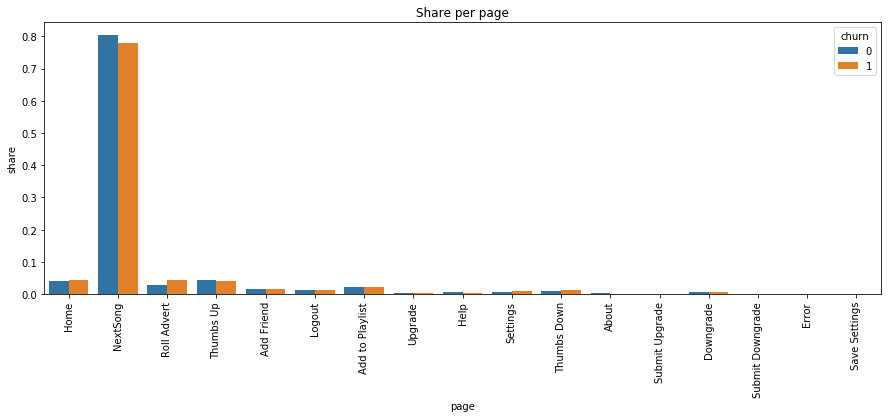

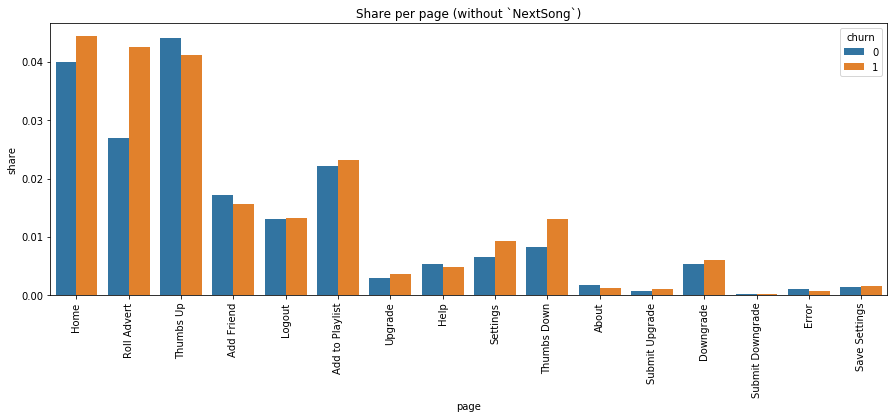

In [64]:
# Plot share per page
pages_pandas_plot = pages_pandas.groupby('churn').mean().drop('userId', axis=1).unstack().reset_index()
pages_pandas_plot.columns = ['page', 'churn', 'share']

# All pages
plt.figure(figsize=(15, 5))
plt.title("Share per page")
sns.barplot(x = 'page', y = 'share', hue = 'churn', data = pages_pandas_plot)
plt.xticks(rotation=90)
plt.show()

# Without Nextsong
plt.figure(figsize=(15, 5))
plt.title("Share per page (without `NextSong`)")
sns.barplot(x = 'page', y = 'share', hue = 'churn', data = pages_pandas_plot[pages_pandas_plot.page!='NextSong'])
plt.xticks(rotation=90)
plt.show()

### Average plays per song

In [65]:
def calculate_average_plays_per_song(user_log):
    """ Calculates how often users on average listen to the same song
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average plays per sond per user
    
    """
    
    plays = user_log.filter(user_log.page == 'NextSong')\
                         .groupBy('userId').agg((F.count('song') / F.countDistinct('song'))\
                                                .alias('Average Plays Per Song'))
    
    return plays

In [66]:
plays = calculate_average_plays_per_song(user_log)

In [67]:
# Make pandas dataframe for exploration
plays_pandas = plays.toPandas()
plays_pandas['churn'] = plays_pandas['userId'].isin(churn_users).astype(int)
plays_pandas.head()

,userId,Average Plays Per Song,churn
0,148,1.041885,0
1,85,1.178234,0
2,137,1.006536,0
3,65,1.150245,0
4,200001,1.008772,1


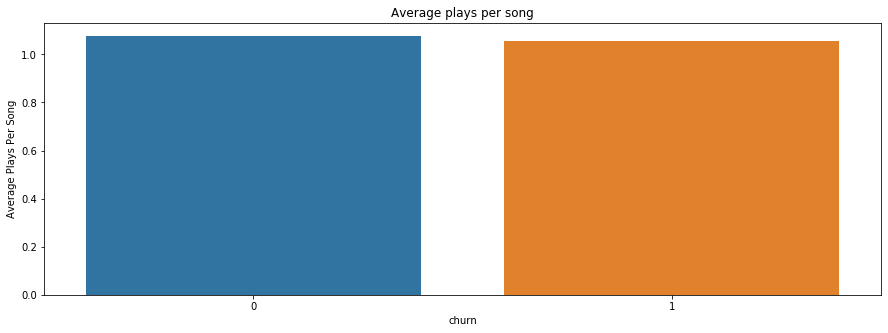

In [68]:
# Plot length per session 
plays_pandas_plot = plays_pandas.groupby('churn', as_index=False)['Average Plays Per Song'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average plays per song")
sns.barplot(x = 'churn', y = 'Average Plays Per Song', data = plays_pandas_plot)
plt.show()

# Modeling
For the model training we first need to merge our features into a single data frame. In addition, we should perform a standardization of all numerical variables, since different feature scales might weaken our models. 

Before we start with the training and comparison of different models, I first split the data set into 80% training and 20% test data. We use the training data to compare three classifiers each with various hyper parameter combinations in a five fold cross validation. Only with the winning model, we will make predictions on the test data in order to come up with a final assessment of our results.

In the following I compare the following models:
* Logistic Regression 
* Random Forest 
* Gradient Boosted Trees

### Preparation

In [69]:
# Merge features and create target label
dfs = [gender, area, device, status, sessions, length, registration, pages, plays]
df = reduce(lambda left, right: left.join(right, how='left', on='userId'), dfs)
is_churn_user = F.udf(lambda x: 1 if x in churn_users else 0, IntegerType())
df = df.withColumn('label', is_churn_user('userId')).drop('userId')

In [70]:
# Convert to pandas and show data
df_pandas = df.toPandas()
df_pandas.head()

,gender,AK,AL,AR,AZ,CA,CO,CT,DC-VA-MD-WV,FL,GA,GA-AL,IA,IL,IL-IN-WI,IL-MO,IN,KY,KY-IN,LA,MA-NH,MD,MD-WV,MI,MN-WI,MO-IL,MO-KS,MS,MT,NC,NC-SC,NE-IA,NH,NJ,NV,NY,NY-NJ-PA,OH,OH-KY-IN,OK,OR,OR-WA,PA,PA-NJ,PA-NJ-DE-MD,RI-MA,SC,SC-NC,TN,TN-MS-AR,TN-VA,TX,UT,UT-ID,VA,VA-NC,WA,WI,WV,Linux,Mac,Windows,iPad,iPhone,Pay Status,Sessions Per Week,Length Per Session,Days Since Registration,Home,NextSong,Roll Advert,Thumbs Up,Add Friend,Logout,Add to Playlist,Upgrade,Help,Settings,Thumbs Down,About,Submit Upgrade,Downgrade,Submit Downgrade,Error,Save Settings,Average Plays Per Song,label
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.332315,132.355556,72.550926,0.050193,0.768340,0.061776,0.054054,0.013514,0.017375,0.009653,0.005792,0.005792,0.005792,0.005792,0.001931,0.000000,0.000000,0.000000,0.000000,0.000000,1.041885,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.552077,370.846341,111.870116,0.035927,0.827460,0.007551,0.043936,0.013272,0.012357,0.024714,0.001602,0.005492,0.005721,0.008696,0.001373,0.000686,0.009611,0.000458,0.000458,0.000686,1.178234,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.333079,211.261111,131.351968,0.057416,0.736842,0.047847,0.038278,0.038278,0.023923,0.019139,0.019139,0.004785,0.004785,0.004785,0.000000,0.004785,0.000000,0.000000,0.000000,0.000000,1.006536,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2.553604,384.174638,74.678993,0.031447,0.830582,0.003145,0.043632,0.020833,0.008255,0.026730,0.001179,0.005110,0.009041,0.006682,0.002358,0.000393,0.007862,0.000000,0.000000,0.002752,1.150245,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.840479,83.508333,15.908194,0.064103,0.737179,0.019231,0.064103,0.000000,0.025641,0.019231,0.006410,0.006410,0.038462,0.006410,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,1.008772,1


In [107]:
# Capture numeric and binary variable names
binary_features = df_pandas.loc[:,:'Pay Status'].columns.tolist()
numeric_features = df_pandas.loc[:,'Sessions Per Week':'Average Plays Per Song'].columns.tolist()

# Perform random split into train and test data
train, test = df.randomSplit([0.8, 0.2], seed=50)

# Prepare assembling and scaling of numeric features
assembler_numeric = VectorAssembler(inputCols=numeric_features, outputCol="numericFeatures")
scaler_numeric = StandardScaler(inputCol="numericFeatures", outputCol="numericFeaturesScaled", 
                                withMean=True, withStd=True)

# Prepare assembling of all features
assembler_total = VectorAssembler(inputCols=binary_features+["numericFeaturesScaled"], outputCol="features")

### Logistic Regression

In [186]:
£# Logistic Regression
lr = LogisticRegression()
pipeline_lr = Pipeline(stages=[assembler_numeric, scaler_numeric, assembler_total, lr])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 25]) \
    .addGrid(lr.regParam, [0, 0.1]) \
    .addGrid(lr.elasticNetParam, [0, 0.5]) \
    .build()

cv_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                          numFolds=5,
                          seed=50) 

start = time.time()
cvModel_lr = cv_lr.fit(train)
end = time.time()

print("Cross validation for logistic regression was successful and took {:.2f} seconds".format(end - start))

Cross validation for logistic regression was successful and took 1252.48 seconds


In [187]:
# Show results
grid_lr = pd.DataFrame([list(cv.values()) for cv in cvModel_lr.getEstimatorParamMaps()], columns = ['maxIter', 'regParam', 'elasticNetParam'])
grid_lr['score'] = cvModel_lr.avgMetrics
grid_lr

,maxIter,regParam,elasticNetParam,score
0,10,0.0,0.0,0.685421
1,10,0.0,0.5,0.685421
2,10,0.1,0.0,0.684820
3,10,0.1,0.5,0.676646
4,25,0.0,0.0,0.661308
5,25,0.0,0.5,0.661308
6,25,0.1,0.0,0.694829
7,25,0.1,0.5,0.676646


### Random Forest

In [193]:
# Random Forest
rf = RandomForestClassifier(seed=50)
pipeline_rf = Pipeline(stages=[assembler_numeric, scaler_numeric, assembler_total, rf])

paramGrid_rf = ParamGridBuilder() \
            .addGrid(rf.numTrees, [10, 20, 50]) \
            .addGrid(rf.maxDepth, [3, 5, 8]) \
            .build()

cv_rf = CrossValidator(estimator=pipeline_rf,
                        estimatorParamMaps=paramGrid_rf,
                        evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                        numFolds=5,
                        seed=50)

start = time.time()
cvModel_rf = cv_rf.fit(train)
end = time.time()

print("Cross validation for random forest was successful and took {:.2f} seconds".format(end - start))

Cross validation for random forest was successful and took 1131.51 seconds


In [194]:
# Show results
grid_rf = pd.DataFrame([list(cv.values()) for cv in cvModel_rf.getEstimatorParamMaps()], columns = ['numTrees', 'maxDepth'])
grid_rf['score'] = cvModel_rf.avgMetrics
grid_rf

,numTrees,maxDepth,score
0,10,3,0.748019
1,10,5,0.762748
2,10,8,0.779799
3,20,3,0.741807
4,20,5,0.793292
5,20,8,0.792674
6,50,3,0.759858
7,50,5,0.792979
8,50,8,0.823566


### Gradient Boosted Trees

In [196]:
# Gradient Boosted Trees
gbt = GBTClassifier(seed=50)
pipeline_gbt = Pipeline(stages=[assembler_numeric, scaler_numeric, assembler_total, gbt])

paramGrid_gbt = ParamGridBuilder() \
            .addGrid(gbt.maxIter, [10, 20, 50]) \
            .addGrid(gbt.maxDepth, [3, 5, 8]) \
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,
                        estimatorParamMaps=paramGrid_gbt,
                        evaluator=MulticlassClassificationEvaluator(metricName = 'f1'),
                        numFolds=5,
                        seed=50)

start = time.time()
cvModel_gbt = cv_gbt.fit(train)
end = time.time()

print("Cross validation for gradient boosted trees was successful and took {:.2f} seconds".format(end - start))

Cross validation for gradient boosted trees was successful and took 6645.00 seconds


In [197]:
# Show results
grid_gbt = pd.DataFrame([list(cv.values()) for cv in cvModel_gbt.getEstimatorParamMaps()], columns = ['maxIter', 'maxDepth'])
grid_gbt['score'] = cvModel_gbt.avgMetrics
grid_gbt

,maxIter,maxDepth,score
0,10,3,0.811942
1,10,5,0.773743
2,10,8,0.783744
3,20,3,0.811942
4,20,5,0.773743
5,20,8,0.783744
6,50,3,0.809267
7,50,5,0.772518
8,50,8,0.783744


### Evaluation
The best model from cross validation is the Random Forest with the parameters numTrees = 50 and maxDepth = 8, and an average F1 score of 0.82. This is a respectable result considering that we are currently working only on a small subset of the overall data.

In [254]:
# Select the winning model
best_score = 0
for cv in [cvModel_lr, cvModel_rf, cvModel_gbt]:
    
    if max(cv.avgMetrics) > best_score:
        best_model = cv.bestModel
        best_score = max(cv.avgMetrics)

print("The best model with an average F1 score of {:.2f} is {}".format(best_score, best_model))
print()
print(best_model.stages[-1].extractParamMap())

The best model with an average F1 score of 0.82 is PipelineModel_8606141991fd

{Param(parent='RandomForestClassifier_70e6d70e9399', name='featuresCol', doc='features column name.'): 'features', Param(parent='RandomForestClassifier_70e6d70e9399', name='labelCol', doc='label column name.'): 'label', Param(parent='RandomForestClassifier_70e6d70e9399', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='RandomForestClassifier_70e6d70e9399', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability', Param(parent='RandomForestClassifier_70e6d70e9399', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction', Param(parent='RandomForestClassifier_70e6d70e9399', name='seed', doc='random seed.'): 50, Param(parent='RandomForestClassifier

For a final assessment of the results, we apply the winning model to the independent test data. I therefore let the model make a prediction for each observation of the test set and compare it with the actual class. By doing so, we come up with a F1 score of 0.94 on the test set.

In [255]:
# Use winning model to make predictions on the test set
predictions = best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
test_f1_score = evaluator.evaluate(predictions)
print("The F1 score on the test data is {:.2f}".format(test_f1_score))

The F1 score on the test data is 0.94


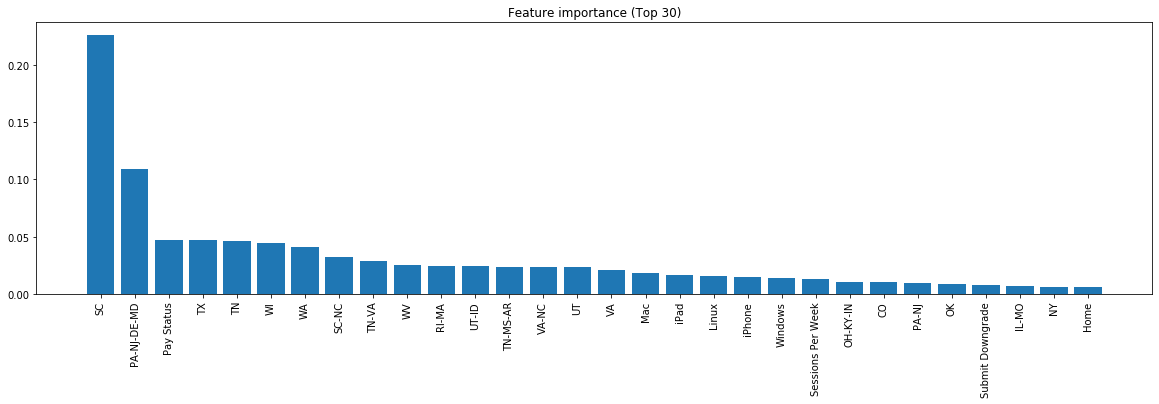

In [259]:
# Plot feature importance
features = numeric_features+binary_features
d = best_model.stages[-1].featureImportances
importances = []
for i in range(len(features)):
    importances.append((features[i], d[i]))

plt.figure(figsize=(20, 5))
plt.title("Feature importance (Top 30)")
importance = pd.DataFrame.from_records(importances).sort_values(1, ascending=False).iloc[:30]
plt.bar(x=importance[0], height=importance[1])
plt.xticks(rotation=90)
plt.show()

In [264]:
test.toPandas().shape

(36, 87)

# Conclusion

### Reflection
Starting with the positive things, I think that the design and selection of meaningful features worked well in this analysis. I spent a lot of time with conceptual considerations in deriving the features. And at least the results give an indication that this might have been worth it, as the F1 score is decent for almost all models.
Shortcomings exist especially in the selection of hyper parameters in the model selection phase. On the one hand, I lack the experience to select proper hyper parameters myself. On the other hand, I lack the computing power necessary for further inflation of the hyper parameter space. It is obvious that without these restrictions additional model improvements would have been possible.
Another weakness lies in the small sample size we are working with. This makes a conclusive assessment of our prediction model nearly impossible. There have been only 36 users in the test data set, of which no more than 9 were churners. Accordingly, the F1 score would probably react very strongly to changes in the test group formation.


### Potential improvements
I see a number of promising opportunities for improvement. 
Probably the greatest possible lever would be an increase in the amount of data used for model training. In this project, we have only worked with a small subset of the original user log data and thus used only a fraction of the available information. Therefore,  my next goal is to get the script running on an AWS cluster and extend the analysis to the full data set.
On this occasion I would also increase the hyper parameter space of the three selected models. I would consider more parameters in general, but also test more possible values for each of them. 
Last but not least, I see some additional potential in the feature selection process. I have spent only little time excluding superfluous, non-significant features. Increased efforts in this area might further increase the predictive power of our models.